In [1]:
#installs
!pip install fsspec==2023.9.2
!pip install -U datasets
!pip install pandas numpy tensorflow matplotlib torch
!pip install transformers
!pip install tensorflow
!pip install scikit-learn
!pip install librosa
!pip install seaborn


In [1]:
#imports for Machine and Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from scipy.special import rel_entr
from sklearn.model_selection import KFold


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


#imports for data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#other imports
from datasets import load_dataset
import librosa
import random
import os




/Users/abhinavramalingam/Documents/Uppsala/NCML/Project/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA PROCESSING

In [7]:
SEED = 42
BATCH_SIZE = 32
N_MELS = 128
MAX_LEN = 300

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


In [2]:
ds = load_dataset("AbstractTTS/IEMOCAP", split="train", download_mode="force_redownload")
ds[0]

Generating train split: 100%|██████████| 10039/10039 [00:01<00:00, 7225.72 examples/s]


{'file': 'Ses01F_impro01_F000.wav',
 'audio': {'path': 'Ses01F_impro01_F000.wav',
  'array': array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
         -0.00317383, -0.00418091]),
  'sampling_rate': 16000},
 'frustrated': 0.0062500000931322575,
 'angry': 0.0062500000931322575,
 'sad': 0.0062500000931322575,
 'disgust': 0.0062500000931322575,
 'excited': 0.0062500000931322575,
 'fear': 0.0062500000931322575,
 'neutral': 0.949999988079071,
 'surprise': 0.0062500000931322575,
 'happy': 0.0062500000931322575,
 'EmoAct': 2.3333330154418945,
 'EmoVal': 2.6666669845581055,
 'EmoDom': 2.0,
 'gender': 'Female',
 'transcription': ' Excuse me.',
 'major_emotion': 'neutral',
 'speaking_rate': 5.139999866485596,
 'pitch_mean': 202.79881286621094,
 'pitch_std': 76.12785339355469,
 'rms': 0.00788376946002245,
 'relative_db': -17.938434600830078}

In [3]:
TARGET_EMOTIONS = ['happy', 'sad', 'angry', 'neutral']

def normalize_emotion(e):
    if e == 'excited':
        return 'happy'
    return e if e in TARGET_EMOTIONS else None


In [4]:
#LABEL ENCODING
def process_label(example):
    emotion = normalize_emotion(example['major_emotion'])
    if emotion is None:
        return None
    example['label'] = TARGET_EMOTIONS.index(emotion)
    return example

processed_ds = ds.filter(lambda x: normalize_emotion(x['major_emotion']) is not None)
processed_ds = processed_ds.map(process_label)


Map: 100%|██████████| 6877/6877 [00:03<00:00, 2147.14 examples/s]


In [5]:
# MFCC EXTRACTION
def extract_mfcc(example, n_mfcc=13, max_len=300):
    y = example['audio']['array']
    sr = example['audio']['sampling_rate']
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]
    example['mfcc'] = mfcc.astype(np.float32)
    return example

processed_ds = processed_ds.map(extract_mfcc)

X = np.array([example['mfcc'] for example in processed_ds])
y = np.array([example['label'] for example in processed_ds])

X_flat = X.reshape(X.shape[0], -1)

Map: 100%|██████████| 6877/6877 [03:55<00:00, 29.22 examples/s] 


In [8]:
#TRAIN_TEST_SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X_flat, y, test_size=0.2, stratify=y, random_state=SEED
)

In [9]:
#DATASETS AND DATALOADERS
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MFCCDataset(X_train, y_train)
val_dataset = MFCCDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# RANDOM FOREST

Accuracy: 48.62%

Classification Report:
               precision    recall  f1-score   support

       happy       0.46      0.71      0.56       527
         sad       0.56      0.57      0.57       250
       angry       0.62      0.28      0.38       254
     neutral       0.42      0.23      0.30       345

    accuracy                           0.49      1376
   macro avg       0.52      0.45      0.45      1376
weighted avg       0.50      0.49      0.46      1376



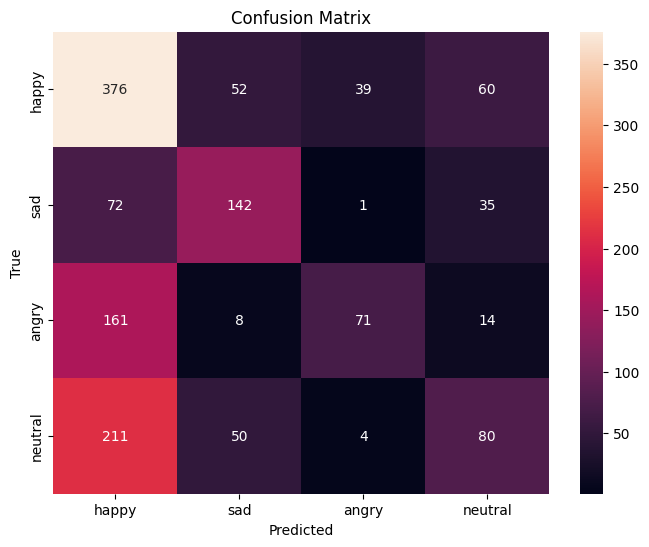

In [15]:
# RANDOM FOREST CLASSIFIER
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
acc = 100 * accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['happy', 'sad', 'angry', 'neutral'])

print(f"Accuracy: {acc:.2f}%\n")
print("Classification Report:\n", report)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['happy', 'sad', 'angry', 'neutral'], yticklabels=['happy', 'sad', 'angry', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
